# The Battle of the Neighbourhoods

### Introduction

New York is known as a “melting pot” of cultures and communities due to it being a key port for immigration. This has led to New York being the most linguistically diverse cities with as many as 800 languages spoken throughout.

This analysis will focus on the most populous county in New York State, Brooklyn. With around 2.5million residents, the borough maintains a distinct culture with many neighbourhoods being ethnic enclaves. Brooklyn has dozens of neighbourhoods that represent many of the major culturally identified groups of New York City and such a diverse culture brings a huge variety in restaurant cuisines, from Mexican food trucks, to your Italian family-owned restaurants. You definitely want to make sure you're getting the best Mexican food in the area so one thing is key…location, location, location! 

This project aims to analyse current Mexican restaurants in Brooklyn to determine which is the best neighbourhood for the client - a food blogger who has travelled to Brooklyn to write a report on Mexican cuisine. 

### The Problem

I will attempt to find answers to the following questions by firstly listing and visualising neighbourhoods of Brooklyn that have excellent Mexican restaurants.
1. What neighborhoods have the most Mexican restaurants in Brooklyn?
2. Which areas lack Mexican restaurants?
3. What is the best area to live/stay in if you want try the most highly rated Mexican restaurants in Brooklyn? 

### Data sources

With Brooklyn’s ever growing population and diversity in cultures there is significant variety in cuisines and restaurants. For this project I will use the following data sources:
1. New York City data containing Boroughs and Neighbourhoods as well as latitude and longitude.  
    Data source: https://cocl.us/new_york_dataset  
    This dataset contains the information detailed above and will be used as the starting point to exploring Brooklyn. 
      
2. Mexican restaurants for Brooklyn by neighbourhood  
    Data source: Foursquare API  
    This will provide information about all venues including name, location, menu, and photos. This will be the main data source as the information on Mexican restaurants will be available from this.   

### Methodology

1. Collect New York data from "https://cocl.us/new_york_dataset"
2. Filter data to Brooklyn only.
3. Find all venues for each neighbourhood in Brooklyn.
4. Filter to only Mexican restaurant venues.
5. Using Foursquare API I will collect ratings, tips, and like count for the Mexican restaurants. 
5. Sort the data using Ratings.
6. Visualise the ranking of neighbourhoods using Folium.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

print("Libraries imported")

Libraries imported


Now I will use geopy to get the latitude and longitude of a given location.

In [2]:
def geo_location(address):
    #location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

I will now extract the New York City data including boroughs, neighbourhoods, latitude, and longitude

In [3]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    #define columns
    column_names = ['Borough','Neighborhood','Latitude','Longitude']
    
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [4]:
new_york_data=get_new_york_data()

new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(new_york_data['Borough'].unique()),
        new_york_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


There are 306 neighbourhoods in New York, but I want to cut this down so that I only have neighborhoods in Brooklyn

In [6]:
brooklyn = new_york_data[new_york_data['Borough']=='Brooklyn'].reset_index(drop=True)
brooklyn.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


In [7]:
brooklyn.shape

(70, 4)

According to the dataset there are 70 Neighbourhoods in Brooklyn. I will now get the geographical coordinates of Brooklyn and visualise Brooklyn with the neighbourhoods imposed on top.

In [8]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Brooklyn are {}, {}'.format(latitude,longitude))

The geographical coordinates of Brooklyn are 40.6501038, -73.9495823


In [9]:
#Creating the map of Brooklyn

map_brooklyn = folium.Map(location=[latitude,longitude],zoom_start=12)

#Adding markers
for lat, lng, label in zip(brooklyn['Latitude'], brooklyn['Longitude'], brooklyn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

The map above is showing all the neighbourhoods in Brooklyn. Now that we have this information, we can start utilising Foursquare API to explore the neighbourhoods and segment them.  
I will define a function to get the top 100 venues with a radius of 1000 meters.

In [10]:
CLIENT_ID = 'PH2GFHCPGXGZINDQCQDF10L5M1G3MA4Q0CF4WV1V3TMINB5O'
CLIENT_SECRET = 'XHJOHP1M5B1CPOJJ0JHR0TWLS2BEEM0YYV1KL2C1SA3SLEWF'
VERSION = '20210201'
LIMIT = 100
RADIUS = 1000

In [11]:
def get_venues(lat,lng):
    
    #URL to get data from foursquare API
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [12]:
def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        venue_id,
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION)
       
    results = requests.get(url).json()
    print(results)
    if(results['meta']['code']==200):
        venue_data=results['response']['venue']
        venue_details=[]
        try:
            venue_id=venue_data['id']
            venue_name=venue_data['name']
            venue_likes=venue_data['likes']['count']
            venue_rating=venue_data['rating']
            venue_tips=venue_data['tips']['count']
            venue_details.append([venue_id,venue_name,venue_likes,venue_rating,
            venue_tips])
        except KeyError:
            pass
        
        column_names=['ID','Name','Likes','Rating','Tips']
        df = pd.DataFrame(venue_details,columns=column_names)
        return df

In [13]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_venues=pd.DataFrame(columns=column_names)
count=1
for row in brooklyn.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_resturants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(brooklyn),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(mexican_resturants)))
    for resturant_detail in mexican_resturants.values.tolist():
        id, name , category=resturant_detail
        mexican_venues = mexican_venues.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 70 ) Mexican Resturants in Bay Ridge, Brooklyn:0
( 2 / 70 ) Mexican Resturants in Bensonhurst, Brooklyn:0
( 3 / 70 ) Mexican Resturants in Sunset Park, Brooklyn:8
( 4 / 70 ) Mexican Resturants in Greenpoint, Brooklyn:2
( 5 / 70 ) Mexican Resturants in Gravesend, Brooklyn:1
( 6 / 70 ) Mexican Resturants in Brighton Beach, Brooklyn:0
( 7 / 70 ) Mexican Resturants in Sheepshead Bay, Brooklyn:0
( 8 / 70 ) Mexican Resturants in Manhattan Terrace, Brooklyn:0
( 9 / 70 ) Mexican Resturants in Flatbush, Brooklyn:5
( 10 / 70 ) Mexican Resturants in Crown Heights, Brooklyn:1
( 11 / 70 ) Mexican Resturants in East Flatbush, Brooklyn:0
( 12 / 70 ) Mexican Resturants in Kensington, Brooklyn:3
( 13 / 70 ) Mexican Resturants in Windsor Terrace, Brooklyn:2
( 14 / 70 ) Mexican Resturants in Prospect Heights, Brooklyn:4
( 15 / 70 ) Mexican Resturants in Brownsville, Brooklyn:0
( 16 / 70 ) Mexican Resturants in Williamsburg, Brooklyn:1
( 17 / 70 ) Mexican Resturants in Bushwick, Brooklyn:6
( 18 / 70

I now have all the Mexican restaurants in Brooklyn and I can analyse the data.

In [14]:
mexican_venues.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Sunset Park,49bc364ff964a5201f541fe3,Tacos Matamoros
1,Brooklyn,Sunset Park,4b5415ecf964a520d3b127e3,Ricos Tacos
2,Brooklyn,Sunset Park,4b5cff55f964a520424e29e3,Maria's Bistro Mexicano
3,Brooklyn,Sunset Park,4c9521df82b56dcbc5fbd5aa,Tacos El Bronco
4,Brooklyn,Sunset Park,55a85c0f498ee3c735f1fa8d,Jalapeño Restaurant


In [15]:
mexican_venues.shape

(79, 4)

From this I know that there are 79 Mexican restaurants in Brooklyn neighbourhoods.  
  
Now I will create a bar chart to show which neighbourhoods have the most Mexican restaurants and which have the least

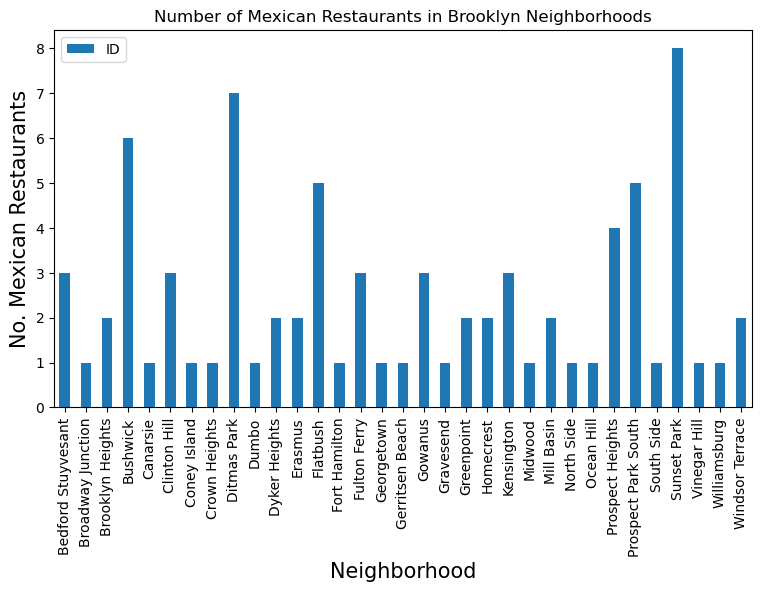

In [16]:
plt.figure(figsize=(9,5), dpi=100)
plt.title('Number of Mexican Restaurants in Brooklyn Neighborhoods')
plt.xlabel('Neighborhood',fontsize=15)
plt.ylabel('No. Mexican Restaurants',fontsize=15)
mexican_venues.groupby('Neighborhood')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

From this plot we can see that Sunset Park and Ditmas Park have the highest number of Mexican restaurants. Therefore, if you wanted to stay in Brooklyn close to multiple Mexican restaurants, Sunset Park or Ditmas Park would be a good place to stay. Or if you were to open a Mexican restuarant with a common Mexican restaurant scene, they might be a good place to start.  
  
Similarly, if you were to open a Mexican restaurant in Brooklyn, and you wanted to open in an area with a small Mexican restaurant scene you might look to areas such as Williamsburg, Canarsie, or Georgetown to name a few, where there is only 1 Mexican restaurant in that neighbourhood.  
  
Let's have look at the ratings of Mexican restaurants across neighbourhoods. This will give us a better idea of the quality of the Mexican restaurants. 

In [17]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
mexican_ratings=pd.DataFrame(columns=column_names)
count=1


for row in mexican_venues.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(mexican_venues),')','processed')
    mexican_ratings = mexican_ratings.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '6019636617ea831a18044f5e'}, 'response': {'venue': {'id': '49bc364ff964a5201f541fe3', 'name': 'Tacos Matamoros', 'contact': {'phone': '7188717627', 'formattedPhone': '(718) 871-7627'}, 'location': {'address': '4508 5th Ave', 'crossStreet': 'btwn 45th & 46th St.', 'lat': 40.647747912107135, 'lng': -74.00762106670679, 'labeledLatLngs': [{'label': 'display', 'lat': 40.647747912107135, 'lng': -74.00762106670679}, {'label': 'entrance', 'lat': 40.647778, 'lng': -74.007718}], 'postalCode': '11220', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4508 5th Ave (btwn 45th & 46th St.)', 'Brooklyn, NY 11220', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tacos-matamoros/49bc364ff964a5201f541fe3', 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/m

In [18]:
mexican_ratings.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Sunset Park,49bc364ff964a5201f541fe3,Tacos Matamoros,131,8.2,61
1,Brooklyn,Sunset Park,4b5415ecf964a520d3b127e3,Ricos Tacos,38,7.5,38
2,Brooklyn,Sunset Park,4b5cff55f964a520424e29e3,Maria's Bistro Mexicano,88,8.7,41
3,Brooklyn,Sunset Park,4c9521df82b56dcbc5fbd5aa,Tacos El Bronco,176,8.7,46
4,Brooklyn,Sunset Park,55a85c0f498ee3c735f1fa8d,Jalapeño Restaurant,5,7.4,2


Now I will save my restaurant to a csv in case there are any issues. I will now refer to the csv instead of calling the API repeatedly.

In [19]:
mexican_ratings.to_csv('mexican_rating.csv',index=False)

In [20]:
mexican_ratings.shape

(79, 7)

Now I will verify the csv file.

In [23]:
mexican_rating_csv=pd.read_csv('mexican_rating.csv')

In [24]:
mexican_rating_csv.shape

(79, 7)

In [25]:
mexican_rating_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Sunset Park,49bc364ff964a5201f541fe3,Tacos Matamoros,131,8.2,61
1,Brooklyn,Sunset Park,4b5415ecf964a520d3b127e3,Ricos Tacos,38,7.5,38
2,Brooklyn,Sunset Park,4b5cff55f964a520424e29e3,Maria's Bistro Mexicano,88,8.7,41
3,Brooklyn,Sunset Park,4c9521df82b56dcbc5fbd5aa,Tacos El Bronco,176,8.7,46
4,Brooklyn,Sunset Park,55a85c0f498ee3c735f1fa8d,Jalapeño Restaurant,5,7.4,2


Great, they match!

In [26]:
mexican_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       79 non-null     object 
 1   Neighborhood  79 non-null     object 
 2   ID            79 non-null     object 
 3   Name          79 non-null     object 
 4   Likes         79 non-null     object 
 5   Rating        79 non-null     float64
 6   Tips          79 non-null     object 
dtypes: float64(1), object(6)
memory usage: 4.4+ KB


Now I will convert likes and tips to float for further analysis

In [27]:
mexican_ratings['Likes']=mexican_ratings['Likes'].astype('float64')
mexican_ratings['Tips']=mexican_ratings['Tips'].astype('float64')

In [28]:
mexican_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       79 non-null     object 
 1   Neighborhood  79 non-null     object 
 2   ID            79 non-null     object 
 3   Name          79 non-null     object 
 4   Likes         79 non-null     float64
 5   Rating        79 non-null     float64
 6   Tips          79 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.4+ KB


Now I will find the Mexican restaurants with the most Likes, highest Ratings and maximum tips.

In [30]:
#Most likes
mexican_ratings.iloc[mexican_ratings['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood            Brooklyn Heights
ID              4f69f2b76d86f87117bb13ab
Name                      Gran Eléctrica
Likes                                640
Rating                               8.6
Tips                                 199
Name: 37, dtype: object

In [31]:
#Highest rating
mexican_ratings.iloc[mexican_ratings['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                     Gowanus
ID              4a88784bf964a520900620e3
Name                Reyes Deli & Grocery
Likes                                142
Rating                               9.2
Tips                                  39
Name: 38, dtype: object

In [32]:
#Most tips
mexican_ratings.iloc[mexican_ratings['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood            Brooklyn Heights
ID              4f69f2b76d86f87117bb13ab
Name                      Gran Eléctrica
Likes                                640
Rating                               8.6
Tips                                 199
Name: 37, dtype: object

So we can see that despite Brooklyn Heights only having 2 Mexican restaurants in the neighbourhood, Gran Electrica has the highest number of tips and likes.  
  
However, Reyes Deli & Grocery in Gowanus has the highest number of ratings.  
  
Now I will look at the average rating of Mexican restaurants in each neighbourhood.

In [33]:
neighborhood_stats = mexican_ratings.groupby('Neighborhood', as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_stats.columns=['Neighborhood','Average Rating']

In [34]:
neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
17,Gowanus,8.833333
19,Greenpoint,8.800000
9,Dumbo,8.600000
3,Bushwick,8.466667
28,South Side,8.400000
24,North Side,8.400000
18,Gravesend,8.300000
14,Fulton Ferry,8.300000
32,Windsor Terrace,8.250000
7,Crown Heights,8.200000


Here we can see the neighbourhoods with the highest average rating of Mexican restaurants. Gowanus and Greenpoint being the top 2.

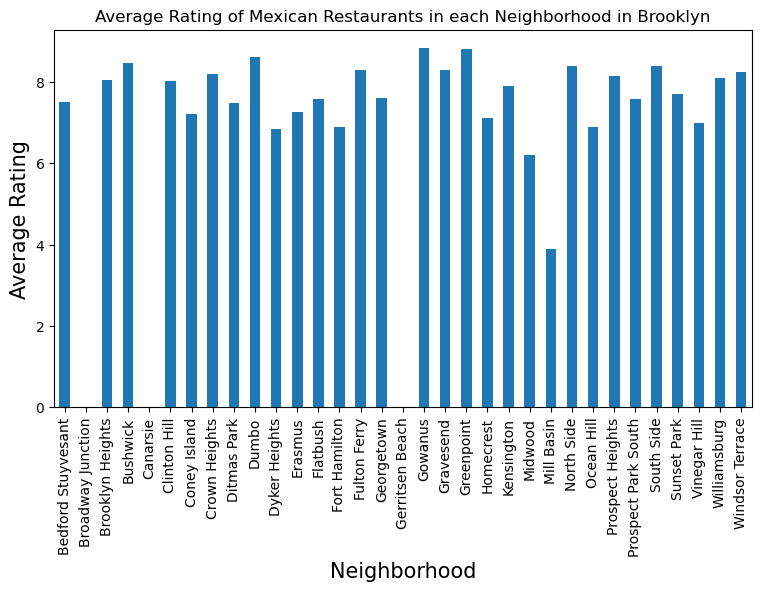

In [36]:
plt.figure(figsize=(9,5),dpi=100)
plt.title('Average Rating of Mexican Restaurants in each Neighborhood in Brooklyn')
plt.xlabel('Neighborhood',fontsize=15)
plt.ylabel('Average Rating', fontsize=15)
mexican_ratings.groupby('Neighborhood').mean()['Rating'].plot(kind='bar')
plt.show()

Now we can see the average rating across Brooklyn neighborhoods, I will visualise those with a rating greater than 8.0

In [37]:
neighborhood_stats=neighborhood_stats[neighborhood_stats['Average Rating']>=8.0]

In [38]:
neighborhood_stats.head()

,Neighborhood,Average Rating
2,Brooklyn Heights,8.050000
3,Bushwick,8.466667
5,Clinton Hill,8.033333
7,Crown Heights,8.200000
9,Dumbo,8.600000


I will join this to the original dataset to get longitude and latitude. 

In [39]:
neighborhood_stats=pd.merge(neighborhood_stats,brooklyn,on='Neighborhood')

In [40]:
neighborhood_stats=neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [41]:
neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.050000
1,Brooklyn,Bushwick,40.698116,-73.925258,8.466667
2,Brooklyn,Clinton Hill,40.693229,-73.967843,8.033333
3,Brooklyn,Crown Heights,40.670829,-73.943291,8.200000
4,Brooklyn,Dumbo,40.703176,-73.988753,8.600000
5,Brooklyn,Fulton Ferry,40.703281,-73.995508,8.300000
6,Brooklyn,Gowanus,40.673931,-73.994441,8.833333
7,Brooklyn,Gravesend,40.595260,-73.973471,8.300000
8,Brooklyn,Greenpoint,40.730201,-73.954241,8.800000
9,Brooklyn,North Side,40.714823,-73.958809,8.400000


Now let's show this on a map.

In [42]:
brooklyn_restaurants = folium.Map(location=geo_location('Brooklyn'),zoom_start=12)

In [44]:
incidents = folium.map.FeatureGroup()

for lat, lng, in neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10,
            color='green',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [45]:
neighborhood_stats['Label']=neighborhood_stats['Neighborhood']+', '+neighborhood_stats['Borough']+'('+neighborhood_stats['Average Rating'].map(str)+')'

In [46]:
for lat, lng, label in neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(brooklyn_restaurants)
    
brooklyn_restaurants.add_child(incidents)

# Conclusions

### I can now answer the following questions that I raised at the beginning of this analysis.

### 1. What neighborhoods have the most Mexican restaurants in Brooklyn?  
#### Sunset Park and Ditmas Park have the most Mexican restaurants in Brooklyn with a total of 8 and 7 respectively.  
  
  
### 2. Which areas lack Mexican restaurants?  
#### There are some areas of Brooklyn with no Mexican restaurants such as Brownsville or Rugby. However, there are many with just 1 such as Williamsburg, Broadway Junction, and Georgetown.
  
  
### 3. What is the best area to live/stay in if you want try the most highly rated Mexican restaurants in Brooklyn?  
#### Looking at the map, the best neighborhood for you to stay in if you want to try the best Mexican restaurant in Brooklyn is Gowanus with an average rating of 8.83.